In [60]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import random
import SimpleITK as sitk

from myshow import myshow
from util import *
%matplotlib inline 

In [2]:
data_path = 'data/validation_data.npz'
batch_size = 1
img_height = 256
img_width = 256

In [3]:
def load_data():
    data = np.load(data_path)
    imgs = data['images']
    masks_gt = data['masks_gt']
    contours_gt = data['contours_gt']
    masks_pred = data['masks_pred']
    contours_pred = data['contours_pred']

    return imgs, masks_gt, contours_gt, masks_pred, contours_pred

In [166]:
def post_processing(image, mask_pred, contour_pred, mask_gt=None, contour_gt=None):
    # load image from numpy array to sitk Image
    image = sitk.GetImageFromArray(image)
    mask_pred = sitk.GetImageFromArray(np.squeeze(mask_pred, axis=2))
    contour_pred = sitk.GetImageFromArray(np.squeeze(contour_pred, axis=2))
    myshow(image, 'raw image')
    myshow(mask_pred, 'segmentation prediction')
    myshow(contour_pred, 'contour prediction')
    
    # otsu filter for segmenattion(S) and contour(C)
    otsuFilter = sitk.OtsuThresholdImageFilter()
    otsuFilter.SetInsideValue(0)
    otsuFilter.SetOutsideValue(1)
    mask_binary = otsuFilter.Execute(mask_pred)
    contour_binary = otsuFilter.Execute(contour_pred)
    myshow(mask_binary, 'segmentation after otsu binary')
    myshow(contour_binary, 'contour after otsu binary')
    
    # erose contour to make it thinner
    erosion_radius = 1
    erosionFilter = sitk.BinaryErodeImageFilter()
    erosionFilter.SetForegroundValue(1)
    erosionFilter.SetKernelRadius(erosion_radius)
    contour_binary = erosionFilter.Execute(contour_binary)
    myshow(contour_binary, 'contour after erosion')
    
    # fill holes in segmentation mask
    fillFilter = sitk.BinaryFillholeImageFilter()
    fillFilter.SetForegroundValue(1)
    mask_binary = fillFilter.Execute(mask_binary)
    myshow(mask_binary, 'segmentation after filling holes')
    
    # only keep the region inside the contour
    mask_inside = np.where(~sitk.GetArrayFromImage(mask_binary).astype(np.bool_) | \
                           sitk.GetArrayFromImage(contour_binary).astype(np.bool_), 0, 1)
    mask_inside = sitk.GetImageFromArray(mask_inside)
    myshow(mask_inside, 'segmentation mask inside the contour')
    
    # label the connected region
    labelFilter = sitk.ConnectedComponentImageFilter()
    mask_label = labelFilter.Execute(mask_inside)
    myshow(mask_label, 'segmentation mask with label')
    print('number of connected region')
    num_region = labelFilter.GetObjectCount()
    print(num_region)
    
    # process each region
    contour_binary_array = sitk.GetArrayFromImage(contour_binary)
    mask_label_array = sitk.GetArrayFromImage(mask_label)
    mask_label_overlap_array = np.zeros(mask_label_array.shape)
    dilation_radius = 1
    dilationFilter = sitk.BinaryDilateImageFilter()
    dilationFilter.SetForegroundValue(1)
    dilationFilter.SetKernelRadius(dilation_radius)
    # each region do dilation, add the valid contour, overlap together
    for i in range(1, num_region):
        # dilation for the region
        mask_label_array_region_raw = np.where(mask_label_array==i, 1, 0)
        mask_label_region_raw = sitk.GetImageFromArray(mask_label_array_region_raw)
#         myshow(mask_label_region_raw, 'one region raw')
        mask_label_region = dilationFilter.Execute(mask_label_region_raw)
#         myshow(mask_label_region, 'one region dilation')
        
        # add valid contour
        mask_label_array_region = sitk.GetArrayFromImage(mask_label_region)
        mask_label_array_add = np.where(mask_label_array_region & contour_binary_array, 1, 0) #valida contour
        mask_label_array_region_final = np.maximum(mask_label_array_add, mask_label_array_region_raw)
        mask_label_region_final = sitk.GetImageFromArray(mask_label_array_region_final)
#         myshow(mask_label_region_final, 'one region add the valid contour')
        mask_label_region_final = fillFilter.Execute(mask_label_region_final)
#         myshow(mask_label_region_final, 'one region after hole filling')
        mask_label_array_region_final = sitk.GetArrayFromImage(mask_label_region_final)
        mask_label_overlap_array = np.where(mask_label_array_region_final, i, mask_label_overlap_array)
    # get overlap label mask
    mask_label_overlap = sitk.GetImageFromArray(mask_label_overlap_array.astype(np.uint64))
    myshow(mask_label_overlap, 'label mask overlap')
    
    # relabel the mask, delete the small region
    min_size = 10
    relabelFilter = sitk.RelabelComponentImageFilter()
    relabelFilter.SetMinimumObjectSize(min_size)
    relabelFilter.SortByObjectSizeOn()
    mask_relabel = relabelFilter.Execute(mask_label_overlap)
    myshow(mask_relabel, 'relabel mask')
        

In [5]:
imgs, masks_gt, contours_gt, masks_pred, contours_pred = load_data()

130


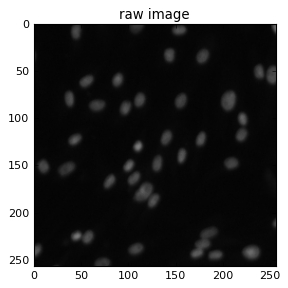

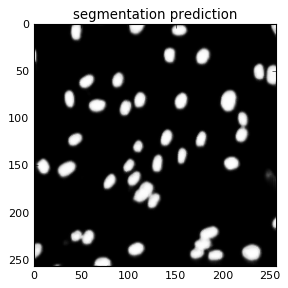

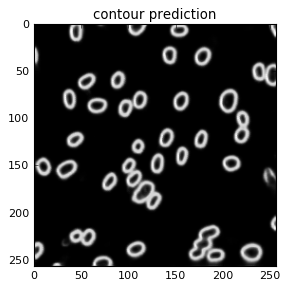

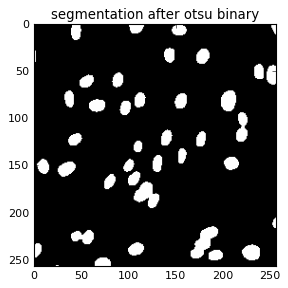

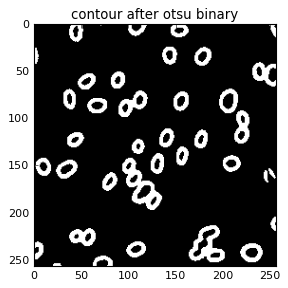

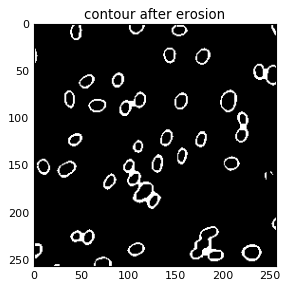

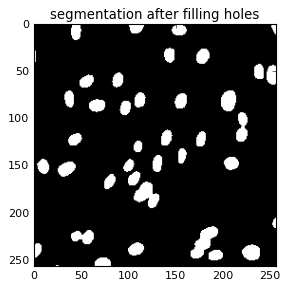

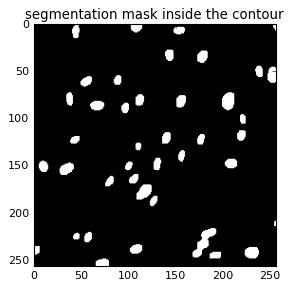

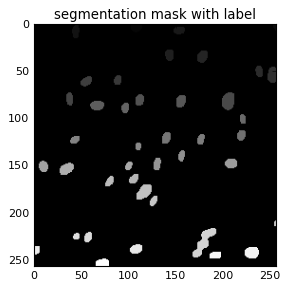

number of connected region
41


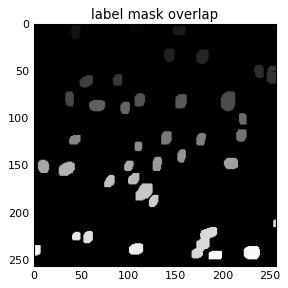

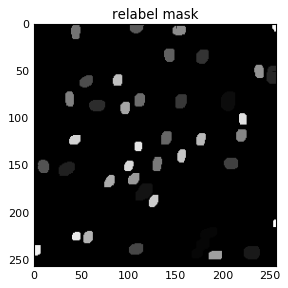

In [168]:
idx = int(imgs.shape[0] * np.random.rand())
print(idx)
img = 255 - imgs[idx]
mask_gt = masks_gt[idx]
contour_gt = contours_gt[idx]
mask_pred = masks_pred[idx]
contour_pred = contours_pred[idx]
post_processing(img, mask_gt, contour_gt, mask_pred, contour_pred)